In [ ]:
# Creates one plot with both ft and ots in it

In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics as mt
import matplotlib.pyplot as plt
import os
from copy import deepcopy

In [2]:
ots_dir = "/home/vincent/Documenten/BachelorsProject/ots_scale/"
ft_dir = "/home/vincent/Documenten/BachelorsProject/ft_scale/"
target_dir = "/home/vincent/Documenten/BachelorsProject/GitHub_Repo/results/"

# Training set size per dataset:
ds_sizes = {
    "100" : 6336,
    "056" : 3554,
    "032" : 1995,
    "018" : 1113,
    "010" : 624,
}

models = {
    "vit_b_16": {"vit": True},
    "swin_b": {"vit": True},
    "beit_b_16": {"vit": True},
    "deit_b_16": {"vit": True},
    "vgg19": {"vit": False},
    "resnet50": {"vit": False},
    "efficientnetv2_m": {"vit": False},
    "convnext_b": {"vit": False}
}

In [4]:
def getArrays(csv_predictions: str, csv_confusion: str):
    """Returns numpy arrays we can work with using scikit-learn"""
    df_pred = pd.read_csv(csv_predictions)
    df_conf = pd.read_csv(csv_confusion)

    true_y = df_pred["actual_idx"].to_numpy()
    pred_y = df_pred[df_conf.columns[1:]].to_numpy()

    # Rows gives actual, columns prediction
    conf = df_conf[df_conf.columns[1:]].to_numpy().T

    return true_y, pred_y, conf

In [5]:
def accFromCsv(csv_predictions):
    csv_confusion = csv_predictions.replace("predictions", "confusion")
    true_y, pred_y, _ = getArrays(csv_predictions, csv_confusion)
    pred_y_max = np.argmax(pred_y, axis=1)
    return { "acc": mt.accuracy_score(true_y, pred_y_max),
             "b_acc": mt.balanced_accuracy_score(true_y, pred_y_max),
             "top3_acc": mt.top_k_accuracy_score(true_y, pred_y, k=3),
             "top5_acc": mt.top_k_accuracy_score(true_y, pred_y, k=5)}

In [6]:
def getDF(source_dir):
    # Creating a long-form dataframe with all datapoints
    df = pd.DataFrame(columns=["ds_num", "ds_size", "model", "acc", "b_acc", "top3_acc", "top5_acc"])

    for file in os.scandir(source_dir):
        if file.is_file() and "test_predictions.csv" in file.name:
            row = accFromCsv(file.path)
            row["model"] = [m for m in models if m in file.name][0]
            row["ds_size"] = [s for s in ds_sizes if s in file.name][0]
            
            # Gave dataset0 different naming, so have to treat it different than 1 to 4
            if "_" + row["ds_size"] not in file.name:
                row["ds_num"] = 0
            else:
                s = "scale"
                row["ds_num"] = int(file.name[file.name.find(s) + len(s)])
            
            row["ds_size"] = int(row["ds_size"])

            row = pd.DataFrame(row, index=[0])
            df = pd.concat([df, row], ignore_index=True)

    df.sort_values(["ds_num", "ds_size", "model"], inplace=True, ignore_index=True)
    return df

ots_df = getDF(ots_dir)
ft_df = getDF(ft_dir)

In [7]:
def newModels(models, df):
    models = deepcopy(models)
    for model in models:
        for size in ds_sizes:
            tmpDf = df[(df.model == model) & (df.ds_size == int(size))]
            models[model][size] = {
                "acc_mean": tmpDf["acc"].mean(),
                "acc_std": tmpDf["acc"].std(),
                "b_acc_mean": tmpDf["b_acc"].mean(),
                "b_acc_std": tmpDf["b_acc"].std()
            }
            models[model][size]["acc_top"] = models[model][size]["acc_mean"] +\
                models[model][size]["acc_std"] / len(tmpDf) ** .5
            models[model][size]["acc_bottom"] = models[model][size]["acc_mean"] -\
                models[model][size]["acc_std"] / len(tmpDf) ** .5
            
            models[model][size]["b_acc_top"] = models[model][size]["b_acc_mean"] +\
                models[model][size]["b_acc_std"] / len(tmpDf) ** .5
            models[model][size]["b_acc_bottom"] = models[model][size]["b_acc_mean"] -\
                models[model][size]["b_acc_std"] / len(tmpDf) ** .5
    return models

ots_models = newModels(models, ots_df)
ft_models = newModels(models, ft_df)

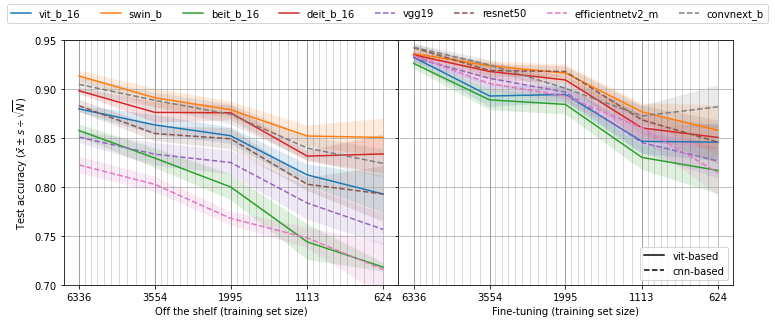

In [26]:
# Plotting mean accuracies of the 5 trials per scale:

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

def plotax(ax, models):

    keys = [key for key in ds_sizes]
    x = [ds_sizes[key] for key in keys]

    num_interp_points = 10
    for idx in range(len(x) - 1):
        interp = np.linspace(x[idx], x[idx+1], num_interp_points, endpoint=False)
        for p in interp:
            ax.axvline(p, color='black', alpha=0.3, linewidth=0.5)

    lines = []

    for model in models:
        y = [models[model][key]["acc_mean"] for key in keys]
        ytop = [models[model][key]["acc_top"] for key in keys]
        ybott = [models[model][key]["acc_bottom"] for key in keys]
        ls = "-" if models[model]["vit"] else "--"
        l, = ax.plot(x, y, label=model, linestyle=ls)
        lines += [l]
        ax.fill_between(x, y1=ybott, y2=ytop, alpha=0.15)

    # plt.legend(framealpha=0.6)
    ax.grid()
    ax.set_xscale("log")
    ax.invert_xaxis()
    ax.minorticks_off()
    ax.set_xticks(x, [str(idx) for idx in x])
    ax.set_ylim(top=0.95, bottom=0.7)

    return lines


plotax(ax1, ots_models)
lines = plotax(ax2, ft_models)
plt.subplots_adjust(wspace=.0)

ax1.set_ylabel(r"Test accuracy ($\bar{x} \pm s \div \sqrt{N}$)")
ax1.set_xlabel("Off the shelf (training set size)")
ax2.set_xlabel("Fine-tuning (training set size)")

fig.legend(lines, [model for model in models], loc='upper center', ncol=len(lines))

types =  [  plt.Line2D([0], [0], color='black', linestyle="-"),
                plt.Line2D([0], [0], color='black', linestyle="--")]
ax2.legend(types, ['vit-based', 'cnn-based'], loc='lower right')

fig.set_size_inches(12, 4.5)

plt.savefig(os.path.join(target_dir, "scaling_acc.svg"), format="svg")
# plt.show()